In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as pt
import math
import time

In [2]:
def moon(r, w, n, d, show):
    half_n = int(n / 2)
    inner_rad = r - w / 2
    rho = np.ones(half_n) * inner_rad + np.random.rand(half_n) * w
    theta = np.random.rand(half_n) * np.pi
    X = rho * np.array([np.cos(theta), np.sin(theta)])
    Y = np.ones(half_n)

    x = rho * np.array([np.cos(theta), -np.sin(theta)]) + \
        (np.ones(X.shape).T * np.array([r, -d])).T
    y = -np.ones(half_n)

    return np.c_[np.concatenate((X.T, x.T)), np.concatenate((Y.T, y.T))]

In [3]:
def get_placehold(data_dim, labels_dim):
    data_pl = tf.placeholder(tf.float32, shape=[None, data_dim])
    labels_pl = tf.placeholder(tf.float32, shape=[None, labels_dim])
    return data_pl, labels_pl


def fill_feed_dict(data, labels, data_pl, labels_pl):
    feed_dic = {data_pl: data, labels_pl: labels}
    return feed_dic

In [4]:
def inference_core(data, data_unit, hidden_unit):
    weights = tf.get_variable(
        'weights', [data_unit, hidden_unit],
        tf.float32,
        tf.random_normal_initializer(
            stddev=1.0 / math.sqrt(float(hidden_unit))))
    biases = tf.get_variable('biases', [hidden_unit], tf.float32,
                             tf.constant_initializer(0.0))
    hidden = tf.nn.tanh(tf.matmul(data, weights) + biases)
    return hidden


def inference(data, data_unit, hidden1_unit, hidden2_unit):
    with tf.variable_scope('hidden1'):
        hidden1 = inference_core(data, data_unit, hidden1_unit)
    with tf.variable_scope('hidden2'):
        hidden2 = inference_core(hidden1, hidden1_unit, hidden2_unit)
    return hidden2

In [5]:
def loss(logits, labels):
    return tf.nn.l2_loss(logits - labels, name='entrpy')

In [6]:
def training(loss, learning_rate):
    tf.summary.scalar('loss', loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op

In [7]:
def eval_inference_core(data):
    weights = tf.get_variable('weights')
    biases = tf.get_variable('biases')
    hidden = tf.nn.tanh(tf.matmul(data, weights) + biases)
    return hidden


def eval_inference(data):
    with tf.variable_scope('hidden1', reuse=True):
        hidden1 = eval_inference_core(data)
    with tf.variable_scope('hidden2', reuse=True):
        hidden2 = eval_inference_core(hidden1)
    return hidden2


def evaluation(logits, labels):
    #     return tf.reduce_sum(tf.abs(logits-labels))
    return tf.nn.l2_loss(logits - labels)

In [8]:
def show(data):
    fig = pt.figure()
    ax = fig.gca()
    ax.set_aspect('equal')
    pt.scatter(data.T[0, :], data.T[1, :], marker='+')
    pt.show()

In [9]:
def get_contour(data, data_pl, len):
    d_min = data.min(axis=0)
    d_max = data.max(axis=0)
    x = np.linspace(d_min[0], d_max[0], len)
    y = np.linspace(d_min[1], d_max[1], len)
    xv, yv = np.meshgrid(x, y)
    xv.shape = (-1, 1)
    yv.shape = (-1, 1)
    contour_p = np.c_[xv, yv]

    contour_logits = eval_inference(data_pl)
    zv = sess.run(contour_logits, feed_dict={data_pl: contour_p})

    xv.shape = (len, len)
    yv.shape = (len, len)
    zv.shape = (len, len)

    return xv, yv, zv

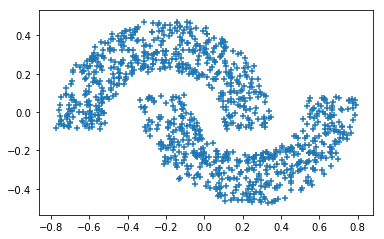

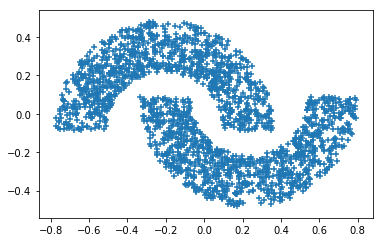

In [10]:
# input_data = moon(10, 6, 3000, 0, True)
orig_data = moon(10, 6, 3000, -4, True)
data_mean = np.mean(orig_data, axis=0)
data_mean[2] = 0
d_max = np.max(np.abs(np.max(orig_data[:, 0:2], axis=0)))
data_max = np.array([d_max, d_max, 1])
input_data = (orig_data - data_mean) / data_max

np.random.shuffle(input_data)
datas = input_data[:1000, :]
data = datas[:, 0:2]
labels = datas[:, 2]
if len(labels.shape) == 1:
    labels.shape = (-1, 1)

test_datas = input_data[1000:, :]
test_data = test_datas[:, 0:2]
test_labels = test_datas[:, 2]
if len(test_labels.shape) == 1:
    test_labels.shape = (-1, 1)

show(data)
show(test_data)

data_pl, labels_pl = get_placehold(data_dim=2, labels_dim=1)
logits = inference(data_pl, 2, 20, 1)

Step 0: loss = 821.65 (0.100 sec)
Step 100: loss = 25.96 (0.001 sec)
Step 200: loss = 0.77 (0.002 sec)
Step 300: loss = 0.49 (0.001 sec)
Step 400: loss = 0.36 (0.001 sec)
Step 500: loss = 0.28 (0.003 sec)
Step 600: loss = 0.22 (0.001 sec)
Step 700: loss = 0.19 (0.001 sec)
Step 800: loss = 0.16 (0.001 sec)
Step 900: loss = 0.14 (0.001 sec)
1.44337


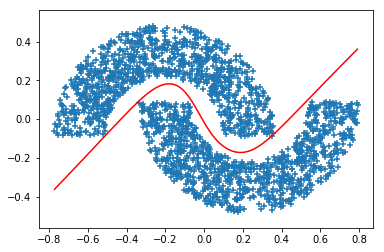

In [11]:
learning_rate = 0.01

loss_op = loss(logits, labels_pl)
train_op = training(loss_op, learning_rate)
summary = tf.summary.merge_all()
init = tf.global_variables_initializer()
sess = tf.Session()
summary_writer = tf.summary.FileWriter('./MLP', sess.graph)
sess.run(init)

for step in range(1000):
    np.random.shuffle(datas)
    start_time = time.time()
    feed_dict = fill_feed_dict(data, labels, data_pl, labels_pl)
    _, loss_value = sess.run([train_op, loss_op], feed_dict=feed_dict)

    duration = time.time() - start_time
    if step % 100 == 0:
        print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))
        summary_str = sess.run(summary, feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()

feed_dict = fill_feed_dict(test_data, test_labels, data_pl, labels_pl)
test_logits = eval_inference(data_pl)
print(sess.run(evaluation(test_logits, labels_pl), feed_dict=feed_dict))

xv, yv, zv = get_contour(test_datas, data_pl, 100)
pt.axis('equal')
pt.scatter(test_datas.T[0, :], test_datas.T[1, :], marker='+')
pt.contour(
    xv,
    yv,
    zv,
    [0],
    colors='red', )
# pt.axis('equal')
pt.show()

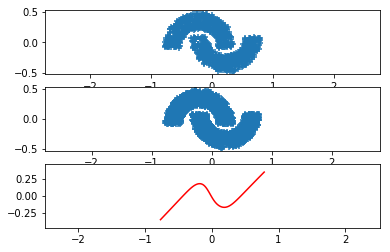

In [17]:
pt.close('all')
_, axis_array = pt.subplots(3)
axis_array[0].axis('equal')
axis_array[0].scatter(data.T[0, :], data.T[1, :], marker='+')
axis_array[1].axis('equal')
axis_array[1].scatter(test_data.T[0, :], test_data.T[1, :], marker='+')
axis_array[2].axis('equal')
axis_array[2].contour(
    xv,
    yv,
    zv,
    [0],
    colors='red', )
pt.show()

In [13]:
# Simple data to display in various forms
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)
# Two subplots, the axes array is 1-d
f, axarr = pt.subplots(2, sharex=True)
axarr[0].plot(x, y)
axarr[0].set_title('Sharing X axis')
axarr[1].scatter(x, y)